### This script implements GAN for Load Synthesis

In [12]:
import os
import sys
import pandas as pd
import numpy as np
import tensorflow as tf
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pdb

from keras.utils import to_categorical
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler

In [2]:
module_path = os.path.abspath(os.path.join('..', 'demand_acep'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
dirpath = os.path.join(module_path, 'data/measurements/test_data')
filename = 'PQube3_comb.csv'

In [4]:
def load_data_label(meter_df, data_shape):
    meter_data = meter_df.values
    data_mean = np.mean(meter_data)
    data_std = np.std(meter_data)
    # limits = [data_mean - (data_std / 2), data_mean + (data_std / 2)]
    limits = [data_mean - data_std, data_mean + data_std]
    data_size = len(meter_data) // data_shape
    # pdb.set_trace()
    data_select = meter_data[:data_size * data_shape]
    data_x = data_select.reshape([data_size, data_shape])
    data_y_label = np.mean(data_x, axis=1)
    data_y = np.empty((data_size, 1))
    data_y[data_y_label < limits[0]] = 0
    data_y[(data_y_label >= limits[0]) & (data_y_label <= limits[1])] = 1
    data_y[data_y_label > limits[1]] = 2
    # data_y = np.select([data_y_label < limits[0], (data_y_label >= limits[0]) & (data_y_label <= limits[1]),
    #                     data_y_label > limits[1]], [0, 1, 2])
    # data_y = data_y.reshape(data_y, (len(data_y), 1))

    return data_x, data_y

In [5]:
# Simulation constants
num_epochs = 70
learning_rate = 1e-4
data_shape = 1440
batch_size = 200
noise_size = 100
mu, sigma = 0, 0.001 # input Gaussian
path_data = '/Users/Tinu/Dropbox/demand_acep/demand_acep/data/measurements/test_data/filled_sample'

meter_df = pd.DataFrame()
for dirpath, dirnames, files in os.walk(path_data, topdown=True):
    for filename in files:
        if filename.lower().startswith('pqube'):
        # if filename.lower().endswith('.csv'):
            read_meter = pd.read_csv(os.path.join(dirpath, filename), header=None, usecols=[1])
            if meter_df.empty:
                meter_df = read_meter.copy()
            else:
                meter_df = meter_df.append(read_meter, sort=False)

# Load data
data_x_us, data_y = load_data_label(meter_df, data_shape)
scaler_x = MinMaxScaler()
data_x = scaler_x.fit_transform(data_x_us)
# train_data = TensorDataset(torch.from_numpy(data_x), torch.from_numpy(data_y))
# data_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
# train_data = TensorDataset(torch.from_numpy(data_x))
data_loader = DataLoader(torch.from_numpy(data_x), batch_size=batch_size, shuffle=True)

In [6]:
# Variables and Main functions
dim_G_1 = noise_size
dim_G_2 = 2000
dim_G_3 = 7000
dim_G_4 = 5000
dim_G_out = data_shape

dim_D_1 = data_shape
dim_D_2 = 10000
dim_D_3 = 7000
dim_D_4 = 1440
dim_D_out = 1


learning_rate = 1e-4

In [7]:
# Graph Initialization
weight_init = tf.truncated_normal_initializer(mean=0.0, stddev=0.02)
bias_init = tf.truncated_normal_initializer(mean=0.0, stddev=0.02)

# Generator
# Input
Z = tf.placeholder(tf.float32, shape=(None, noise_size), name='Z')
G_W1 = tf.get_variable(name='G_Weight_1', dtype=tf.float32, shape=[dim_G_1, dim_G_2], initializer=weight_init)
G_W2 = tf.get_variable(name='G_Weight_2', dtype=tf.float32, shape=[dim_G_2, dim_G_3], initializer=weight_init)
G_W3 = tf.get_variable(name='G_Weight_3', dtype=tf.float32, shape=[dim_G_3, dim_G_4], initializer=weight_init)
G_W4 = tf.get_variable(name='G_Weight_4', dtype=tf.float32, shape=[dim_G_4, dim_G_out], initializer=weight_init)


G_B1 = tf.get_variable(name='G_bias_1', dtype=tf.float32, shape=[dim_G_2], initializer=bias_init)
G_B2 = tf.get_variable(name='G_bias_2', dtype=tf.float32, shape=[dim_G_3], initializer=bias_init)
G_B3 = tf.get_variable(name='G_bias_3', dtype=tf.float32, shape=[dim_G_4], initializer=bias_init)
G_B4 = tf.get_variable(name='G_bias_4', dtype=tf.float32, shape=[dim_G_out], initializer=bias_init)

gen_vars = [G_W1, G_B1, G_W2, G_B2, G_W3, G_B3, G_W4, G_B4]

# Discriminator
# Input
X = tf.placeholder(tf.float32, shape=(None, data_shape), name='X')

D_W1 = tf.get_variable(name='D_Weight_1', dtype=tf.float32, shape=[dim_D_1, dim_D_2], initializer=weight_init)
D_W2 = tf.get_variable(name='D_Weight_2', dtype=tf.float32, shape=[dim_D_2, dim_D_3], initializer=weight_init)
D_W3 = tf.get_variable(name='D_Weight_3', dtype=tf.float32, shape=[dim_D_3, dim_D_4], initializer=weight_init)
D_W4 = tf.get_variable(name='D_Weight_4', dtype=tf.float32, shape=[dim_D_4, dim_D_out], initializer=weight_init)


D_B1 = tf.get_variable(name='D_bias_1', dtype=tf.float32, shape=[dim_D_2], initializer=bias_init)
D_B2 = tf.get_variable(name='D_bias_2', dtype=tf.float32, shape=[dim_D_3], initializer=bias_init)
D_B3 = tf.get_variable(name='D_bias_3', dtype=tf.float32, shape=[dim_D_4], initializer=bias_init)
D_B4 = tf.get_variable(name='D_bias_4', dtype=tf.float32, shape=[dim_D_out], initializer=bias_init)

dis_vars = [D_W1, D_B1, D_W2, D_B2, D_W3, D_B3, D_W4, D_B4]

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
# Generator and Discriminator Function Definition
def generator(z):
    l1 = tf.nn.leaky_relu(tf.matmul(z,  G_W1) + G_B1, .2)
    l2 = tf.nn.leaky_relu(tf.matmul(l1, G_W2) + G_B2, .2)
    l3 = tf.nn.leaky_relu(tf.matmul(l2, G_W3) + G_B3, .2)
    out = tf.nn.tanh(tf.matmul(l3, G_W4) + G_B4)

    return out


def discriminator(x):
    l1 = tf.nn.leaky_relu(tf.matmul(x,   D_W1) + D_B1, .2)
    l2 = tf.nn.leaky_relu(tf.matmul(l1,  D_W2) + D_B2, .2)
    l3 = tf.nn.leaky_relu(tf.matmul(l2,  D_W3) + D_B3, .2)
    out_logit = tf.matmul(l3, D_W4) + D_B4
    out = tf.nn.sigmoid(out_logit)

    return out, out_logit


def noise(n_rows, n_cols):
    # return np.random.normal(mu, sigma, size=(n_rows, n_cols))
    return np.random.uniform(-1., 1., size=(n_rows, n_cols))

In [9]:
# Optimizers and losses
G_sample = generator(Z)
D_real, D_logit_real = discriminator(X)
D_fake, D_logit_fake = discriminator(G_sample)

# Losses
D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_real, labels=tf.ones_like(D_real)))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake, labels=tf.zeros_like(D_fake)))
D_loss = D_loss_real + D_loss_fake
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake, labels=tf.ones_like(D_fake)))

# Optimizers
D_opt = tf.train.AdamOptimizer(learning_rate).minimize(D_loss, var_list=dis_vars)
G_opt = tf.train.AdamOptimizer(learning_rate).minimize(G_loss, var_list=gen_vars)

# Start interactive session
session = tf.InteractiveSession()
# Init Variables
tf.global_variables_initializer().run(session=session)

In [10]:
# Iterate through epochs
fake_saved = []
real_saved = []
for epoch in range(num_epochs):
    for i_batch, sample_batched in enumerate(data_loader):
        # Train Discriminator
        feed_dict = {X: sample_batched, Z: noise(batch_size, noise_size)}
        _, d_error, = session.run([D_opt, D_loss], feed_dict=feed_dict)

        # 2. Train Generator
        feed_dict = {Z: noise(batch_size, noise_size)}
        _, g_error = session.run([G_opt, G_loss], feed_dict=feed_dict)

        if i_batch % 100 == 0:
            save = session.run(G_sample, feed_dict={Z: noise(batch_size, noise_size)})
            fake_saved.append(save)
            # pdb.set_trace()
            array_out = X.eval(session=session, feed_dict={X: sample_batched})
            real_saved.append(array_out)

            print("Iterations: %d\t Discriminator loss: %.4f\t Generator loss: %.4f" % (epoch, d_error, g_error))

Iterations: 0	 Discriminator loss: 1.4476	 Generator loss: 0.5058
Iterations: 1	 Discriminator loss: 1.4997	 Generator loss: 0.4311
Iterations: 2	 Discriminator loss: 1.4482	 Generator loss: 0.6241
Iterations: 3	 Discriminator loss: 1.3669	 Generator loss: 0.6916
Iterations: 4	 Discriminator loss: 1.3716	 Generator loss: 0.6931
Iterations: 5	 Discriminator loss: 1.3746	 Generator loss: 0.6931
Iterations: 6	 Discriminator loss: 1.3710	 Generator loss: 0.6931
Iterations: 7	 Discriminator loss: 1.3674	 Generator loss: 0.6931
Iterations: 8	 Discriminator loss: 1.3464	 Generator loss: 0.6931
Iterations: 9	 Discriminator loss: 1.0664	 Generator loss: 0.6910
Iterations: 10	 Discriminator loss: 1.0305	 Generator loss: 0.6931
Iterations: 11	 Discriminator loss: 1.0181	 Generator loss: 0.6931
Iterations: 12	 Discriminator loss: 1.0138	 Generator loss: 0.6931
Iterations: 13	 Discriminator loss: 1.0104	 Generator loss: 0.6931
Iterations: 14	 Discriminator loss: 1.0098	 Generator loss: 0.6931
Itera

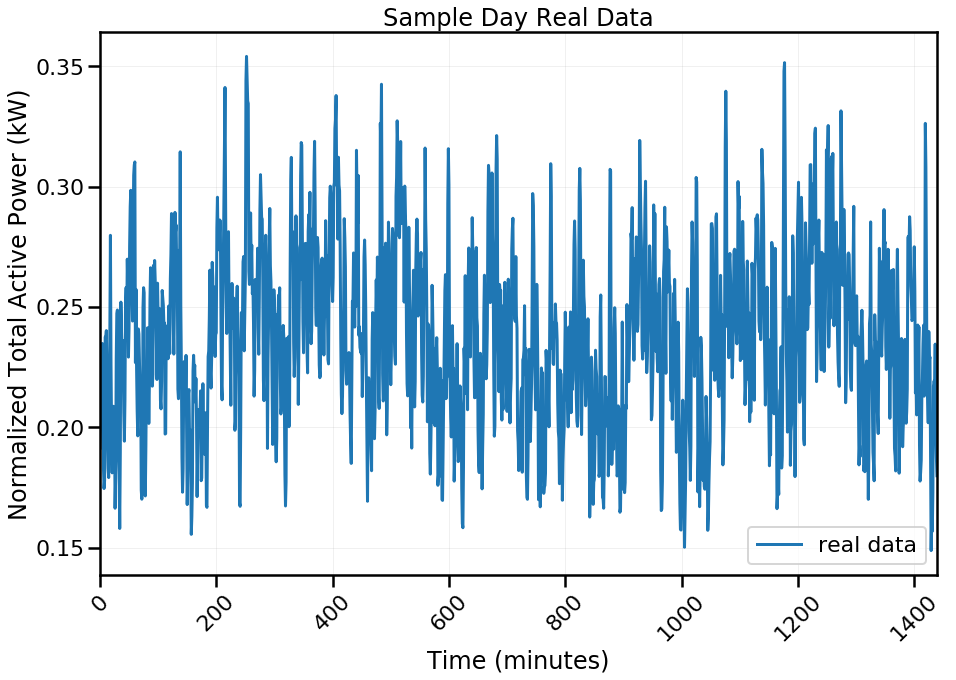

In [13]:
# Plot real and fake data
# real_data = scaler_x.inverse_transform(real_saved)
# fake_data = scaler_x.inverse_transform(fake_saved[75][1])
real_data = real_saved[7][10] # Select a real sample day
fake_data = fake_saved[7][10] # Select a synthetic sample day
sns.set_context('poster')
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
plt.sca(ax)
plt.plot(real_data, label="real data")
plt.legend()
plt.title('Sample Day Real Data')
plt.xlabel('Time (minutes)')
plt.ylabel('Normalized Total Active Power (kW)')
plt.grid(linewidth=0.75, alpha=0.25)
plt.autoscale(enable=True, axis='x', tight=True)
plt.xticks(rotation=45)
plt.show()

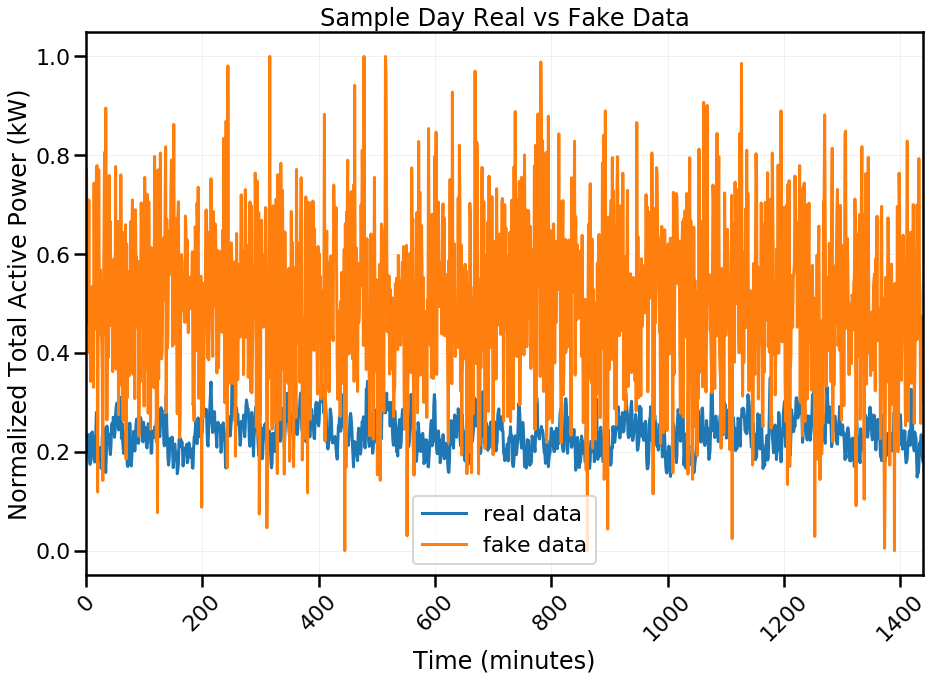

In [14]:
scaler_fx = MinMaxScaler()
fake_data_fit = scaler_fx.fit_transform(fake_saved[7])

sns.set_context('poster')
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
plt.sca(ax)
plt.plot(real_data, label="real data")
plt.plot(fake_data_fit[10], label="fake data")
plt.legend()
plt.title('Sample Day Real vs Fake Data')
plt.xlabel('Time (minutes)')
plt.ylabel('Normalized Total Active Power (kW)')
plt.grid(linewidth=0.75, alpha=0.25)
plt.autoscale(enable=True, axis='x', tight=True)
plt.xticks(rotation=45)
plt.show()